## Import libraries

In [1]:
from geo_utils import *

### Load training data

In [60]:
df = pd.read_csv('./data/cleaned_training_data_v20220509.csv',index_col='mgrs_code')

### Train Dev Test Split

In [3]:
feature_names = df.columns[1:].tolist()

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Feature Standardization

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### Logistic Regression and Random Forest Models

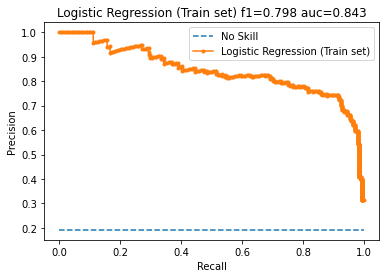

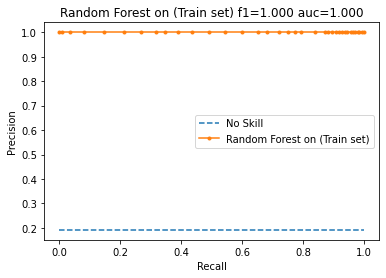

In [5]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_std, y_train)
plot_precision_recall_curve(lr_model, X_train_std, y_train, 'Logistic Regression (Train set)')


rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_std, y_train)
plot_precision_recall_curve(rf_model, X_train_std, y_train, 'Random Forest on (Train set)')

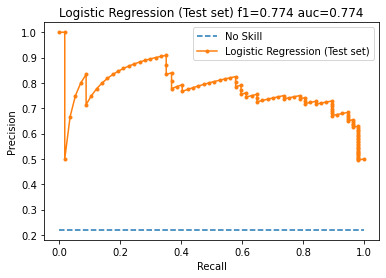

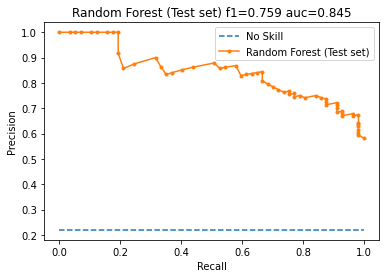

In [6]:
lr_pr_thresholds = plot_precision_recall_curve(lr_model, X_test_std, y_test, 'Logistic Regression (Test set)', return_thresholds=True)

rf_pr_thresholds = plot_precision_recall_curve(rf_model, X_test_std, y_test, 'Random Forest (Test set)', return_thresholds=True)

### XGBoost Model

In [9]:
# base_xgb_model = XGBClassifier(tree_method='hist', seed = 0)

# params = { 'objective': ['binary:logistic'],
#            'max_depth': [6, 9, 12],
#            'learning_rate': [0.01, 0.1],
#            'subsample': np.arange(0.5, 1.0, 0.2),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.2),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.2),
#            'n_estimators': [100, 200, 500]}

# rcv = RandomizedSearchCV(estimator=base_xgb_model,
#                          param_distributions=params,
#                          scoring='f1',
#                          n_iter=100,
#                          cv=5,
#                          verbose=2)

# rcv.fit(X_train_std, y_train)

# xgb_model = rcv.best_estimator_

# print('Best hyper parameters: ', rcv.best_params_)

# Best hyper parameters:  {'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8000000000000002, 'colsample_bylevel': 0.4}

In [10]:
xgb_model = XGBClassifier(**{'tree_method':'hist', 'seed': 0, 'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4})

In [12]:
xgb_model.fit(X_train_std, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.4, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

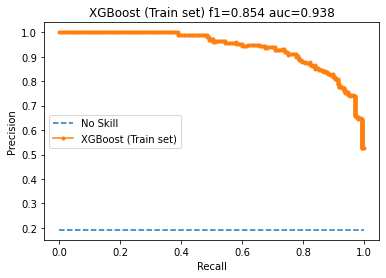

In [13]:
xgb_pr_thresholds = plot_precision_recall_curve(xgb_model, X_train_std, y_train, 'XGBoost (Train set)', return_thresholds=True)

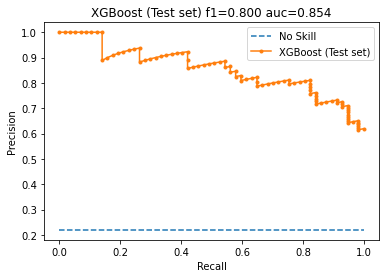

In [14]:
xgb_pr_thresholds = plot_precision_recall_curve(xgb_model, X_test_std, y_test, 'XGBoost (Test set)', return_thresholds=True)

### Probability of false positive for all hamlet settlements

In [27]:
all_df = pd.read_csv('./data/cleaned_all_hamlet_data_v20220521.csv',index_col='mgrs_code')
X_all = all_df.iloc[:,:]
print(X_all.shape)

(538070, 26)


In [28]:
X_all_std = scaler.transform(X_all)

In [31]:
X_all_pred = xgb_model.predict_proba(X_all_std)
print(X_all_pred.shape)

(538070, 2)

In [39]:
all_df['false_posi_proba'] = X_all_pred[:,1]

In [41]:
settlement_extents = gpd.read_feather('./data/ZMB_grid3_settlement_extents_20201222.feather')

hamlet_extents = settlement_extents[settlement_extents['type']=='hamlet']

hamlet_extents = hamlet_extents.merge(all_df['false_posi_proba'].round(3).reset_index(), on='mgrs_code', how='left')

hamlet_extents = explode_geometry(hamlet_extents, id_column = 'mgrs_code', drop_duplicates = True)[['mgrs_code','false_posi_proba','geometry']]

hamlet_extents.loc[hamlet_extents['mgrs_code'].isin(df.index[df['false_posi']==1].tolist()), 'labeled_false_posi'] = 1
hamlet_extents['labeled_false_posi'] = hamlet_extents['labeled_false_posi'].fillna(0) 

hamlet_extents = hamlet_extents.sort_values('false_posi_proba',ascending=False).reset_index(drop=True)

hamlet_extents = add_centroid_column(hamlet_extents, proj2 = 'epsg:32735')

hamlet_extents = hamlet_extents[['mgrs_code', 'false_posi_proba', 'labeled_false_posi', 'geometry_centroid']]

hamlet_extents = gpd.GeoDataFrame(hamlet_extents, geometry='geometry_centroid')

hamlet_extents.to_file(X './data/hamlet_false_positive_probability.geojson',driver='GeoJSON')

In [114]:
temp = hamlet_extents.drop('mgrs_code',axis=1).dropna()
temp['longitude'] = temp.geometry_centroid.x
temp['latitude'] = temp.geometry_centroid.y
temp = temp.drop('geometry_centroid',axis=1)
temp.to_csv('./data/hamlet_false_positive_probability_for_visualization.csv',index=False)

### Visual Inspection

In [91]:
# !pip install --upgrade selenium requests soupsieve beautifulsoup4 html5lib webdriver-manager 

In [92]:
def create_mapbox_url(lat, lon, mapbox_zoom_level, mapbox_url_sample):
    return mapbox_url_sample.split('#')[0]+'#'+str(mapbox_zoom_level)+'/'+str(lat)+'/'+str(lon)

from scraper_functions import *


Done, the environment is ready. Now Teach Me Scrape!



In [103]:
# https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v11.html?title=true&access_token=...
mapbox_url_sample = driver.current_url
mapbox_zoom_level = 18

In [110]:
iter_df = hamlet_extents
uuid_column = 'mgrs_code'
centroid_column = 'geometry_centroid'

comments = []
for i,row in iter_df.iterrows():
    print()
    print(str(i)+'/'+str(len(iter_df)) + '  mgrs_code:',row[uuid_column], ' False Positive Probability:',round(row['false_posi_proba'],2),' Labeled:','Yes' if row['labeled_false_posi']==1 else 'No')
    geom_centroid_shapely_point = row[centroid_column]    
    lon, lat = [float(num) for num in re.findall(r'\((.*?)\)',str(geom_centroid_shapely_point))[0].split()]
    mapbox_url = create_mapbox_url(lat, lon, mapbox_zoom_level, mapbox_url_sample)
    go_to_page(driver, mapbox_url)
    comment = input('next or stop:')
    comments.append((i,comment))
    if comment.lower() == 'stop':
        break
    clear_output()


4/567826  mgrs_code: 35LNE3614_01  False Positive Probability: 0.75  Labeled: No
next or stop:stop
